In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import omegaconf
import torch
import torch.optim as optim

import mbrl.models as models
import mbrl.util.common as common_utils
import mbrl.util.replay_buffer as replay_buffer

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

%load_ext autoreload
%autoreload 2

%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'

cuda:0


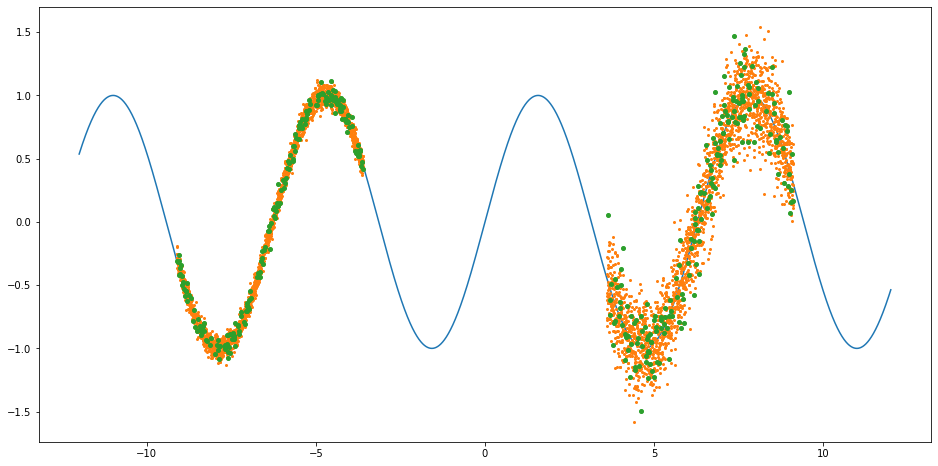

In [2]:
x_data = np.linspace(-12, 12, 10000)
y_data = np.sin(x_data)

train_size = 2000
val_size = 200
x_train = np.zeros(2 * train_size)
y_train = np.zeros(2 * train_size)
x_val = np.zeros(2 * val_size)
y_val = np.zeros(2 * val_size)

# Half with lower noise
train_val_idx_1 = np.random.choice(list(range(1200, 3500)), 
                                   size=train_size + val_size, 
                                   replace=False)
mag = 0.05
x_train[:train_size] = x_data[train_val_idx_1[:train_size]]
y_train[:train_size] = y_data[train_val_idx_1[:train_size]] + mag * np.random.randn(train_size)
x_val[:val_size] = x_data[train_val_idx_1[train_size:]]
y_val[:val_size] = y_data[train_val_idx_1[train_size:]] + mag * np.random.randn(val_size)

# Half with higher noise
train_val_idx_2 = np.random.choice(list(range(6500, 8800)), 
                                   size=train_size + val_size, 
                                   replace=False)
mag = 0.20
x_train[train_size:] = x_data[train_val_idx_2[:train_size]]
y_train[train_size:] = y_data[train_val_idx_2[:train_size]] + mag * np.random.randn(train_size)
x_val[val_size:] = x_data[train_val_idx_2[train_size:]]
y_val[val_size:] = y_data[train_val_idx_2[train_size:]] + mag * np.random.randn(val_size)

plt.figure(figsize=(16, 8))
plt.plot(x_data, y_data, x_train, y_train, '.', x_val, y_val, 'o', markersize=4)
plt.show()

train_size *=2
val_size *= 2

In [3]:
# ReplayBuffer generates its own training/validation split, but in this example we want to
# keep the split generated above, so instead we use two replay buffers. 

num_members = 5
train_buffer = replay_buffer.ReplayBuffer(train_size, (1,), (0,))
val_buffer = replay_buffer.ReplayBuffer(val_size, (1,), (0,))
for i in range(train_size):
    train_buffer.add(x_train[i], 0, y_train[i], 0, False)
for i in range(val_size):
    val_buffer.add(x_val[i], 0, y_val[i], 0, False)
train_dataset, _ = common_utils.get_basic_buffer_iterators(
    train_buffer, 2048, 0, ensemble_size=num_members, shuffle_each_epoch=True)
val_dataset, _ = common_utils.get_basic_buffer_iterators(
    val_buffer, 2048, 0, ensemble_size=1)

In [4]:
ensemble = models.GaussianMLP(
    1, # input size
    1, # output size
    device, 
    num_layers=3, 
    hid_size=64, 
    activation_fn_cfg={"_target_": "torch.nn.SiLU"}, 
    ensemble_size=num_members
)
wrapper = models.OneDTransitionRewardModel(
    ensemble, target_is_delta=False, normalize=True, learned_rewards=False)

/home/jaykay/.local/lib/python3.8/site-packages/hydra/utils.py:32: UserWarning: `OmegaConf.is_none()` is deprecated, see https://github.com/omry/omegaconf/issues/547
  if OmegaConf.is_none(config):


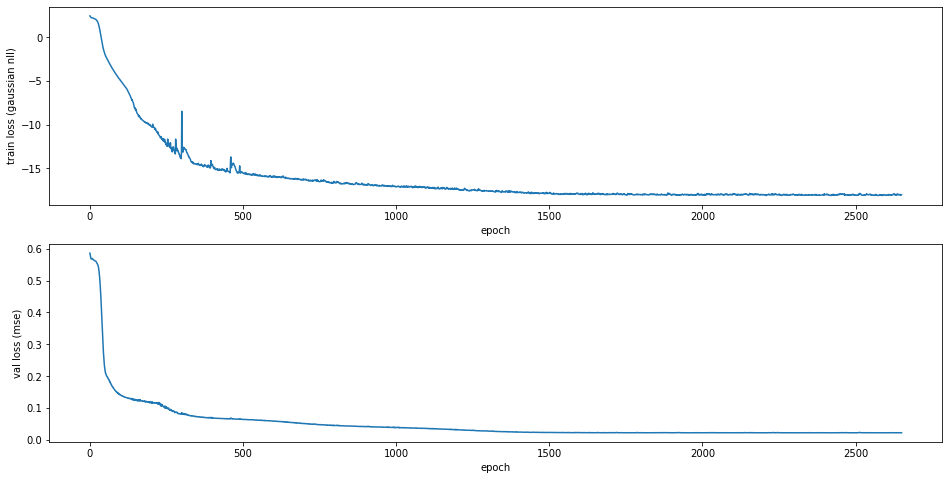

In [5]:
wrapper.update_normalizer(train_buffer.get_all())
trainer = models.ModelTrainer(wrapper, optim_lr=0.001, weight_decay=5e-5)
train_losses, val_losses = trainer.train(
    train_dataset, val_dataset, num_epochs=5000, patience=500)
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].plot(train_losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("train loss (gaussian nll)")
ax[1].plot(val_losses)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("val loss (mse)")
plt.show()

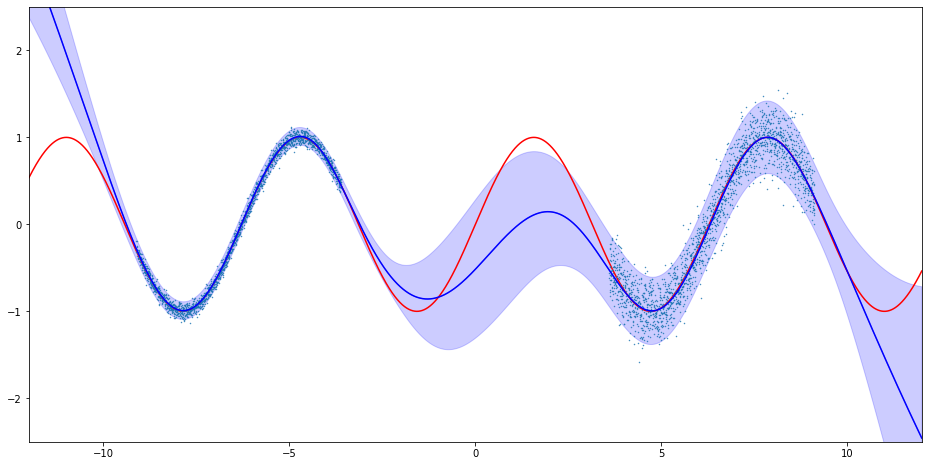

In [6]:
x_tensor = torch.from_numpy(x_data).unsqueeze(1).float().to(device)
x_tensor = wrapper.input_normalizer.normalize(x_tensor)

with torch.no_grad():
    y_pred, y_pred_logvar = ensemble(x_tensor)
    y_pred = y_pred[..., 0]
    y_pred_logvar = y_pred_logvar[..., 0]
y_var_epi = y_pred.var(dim=0).cpu().numpy()
y_var = y_pred_logvar.exp()
y_pred = y_pred.mean(dim=0).cpu().numpy()
y_var_ale = y_var.mean(dim=0).cpu().numpy()

y_std = np.sqrt(y_var_epi + y_var_ale)
plt.figure(figsize=(16, 8))
plt.plot(x_data, y_data, 'r')
plt.plot(x_train, y_train, '.', markersize=0.9)
plt.plot(x_data, y_pred, 'b-', markersize=4)
plt.fill_between(x_data, y_pred, y_pred + 2 * y_std, color='b', alpha=0.2)
plt.fill_between(x_data, y_pred - 2 * y_std, y_pred, color='b', alpha=0.2)
plt.axis([-12, 12, -2.5, 2.5])
plt.show()